In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import os
from utils import *

In [2]:
from PIL import Image

In [3]:
os.chdir(r'E:\study\else\RC-Raspberry-Pi-Car-with-Gesture-Control\realtime_gesture_recog')
print(os.getcwd())

E:\study\else\RC-Raspberry-Pi-Car-with-Gesture-Control\realtime_gesture_recog


In [4]:
PATH_DATA

'./data/train'

# 0. Helper func.

In [31]:
classes=GESTURE_CLASSES

In [5]:
def imshow(img):
    # input: img, tensor CxHxW
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:
# helper functions

def images_to_probs(net, images, gpu=True):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    if gpu:
        preds_tensor=preds_tensor.cpu()
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


In [20]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False, gpu=True):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    if gpu:
        img=img.cpu()
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

# 1. Load data

In [8]:
# load data
data_transform = transforms.Compose([transforms.Resize(64),
#     transforms.CenterCrop(224),
    transforms.Grayscale(),
    transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5], std=[0.5]), # 1 chanel
])
gesture_dataset = datasets.ImageFolder(root=PATH_DATA,transform=data_transform)
dataset_loader = torch.utils.data.DataLoader(gesture_dataset,
                                             batch_size=6, shuffle=True,
                                             num_workers=2)

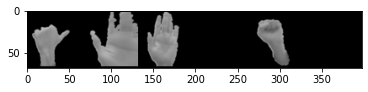

turn_right back_up back_up nothing  idle nothing


In [9]:
# check

# get some random training images
dataiter = iter(dataset_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))
# print labels
print(' '.join('%5s' % GESTURE_CLASSES[labels[j]] for j in range(6)))

In [10]:
images.shape

torch.Size([6, 1, 64, 64])

# 2. CNN

In [11]:
class NaiveNN(nn.Module):
    def __init__(self,num_classes=C_NUM):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(8192,128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# 3. Training with Tensorboard

In [16]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/naive_nn')

In [13]:
model = NaiveNN()

In [14]:
# start tensorboard service
# tensorboard --logdir=runs

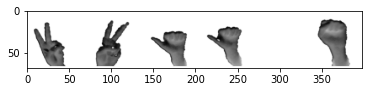

In [21]:
# get some random training images
dataiter = iter(dataset_loader)
images, labels = dataiter.next()

# create grid of images
img_grid = utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [22]:
writer.add_graph(model, images)
writer.close()

In [24]:
# use GPU
torch.cuda.is_available()

True

In [28]:
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

NaiveNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

#### Optimizer

In [26]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [32]:
model.train()
print('start training')
record_intervals = 10
running_loss = 0.0
for epoch in range(30):  # loop over the dataset multiple times

    for i, data in enumerate(dataset_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data  #use CPU
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = F.nll_loss(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % record_intervals == record_intervals-1:    # every 1000 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / record_intervals,
                            epoch * len(dataset_loader) + i)

            # ...log a Matplotlib Figure showing the model's predictions on a
            # random mini-batch
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(dataset_loader) + i)
            running_loss = 0.0
print('Finished Training')



start training
Finished Training


# 4. Save model

In [34]:
# save model
torch.save(model.state_dict(),PATH_MODELS+'/naiveNN_v1')

# 5. Simple test

In [40]:
test_dataset = datasets.ImageFolder(root=r"E:\study\else\RC-Raspberry-Pi-Car-with-Gesture-Control\realtime_gesture_recog\data\naive_test",
                                   transform=data_transform)
testset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=6, shuffle=True,
                                             num_workers=2)

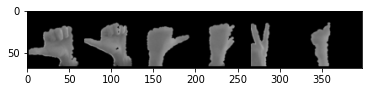

In [42]:
# get some random training images
dataiter = iter(testset_loader)
images, labels = dataiter.next()

# show images
imshow(utils.make_grid(images))

In [45]:
with torch.no_grad():
    images = images.to(device)
    out = model(images)
    _, predicted = torch.max(out.data, 1)

In [54]:
predicted[0]

tensor(0, device='cuda:0')

In [55]:
print(out[0])
sum(out[0])

tensor([-11.1706,  -7.9022,  -0.0151,  -4.9912,  -4.8552, -10.0537],
       device='cuda:0')


tensor(-38.9880, device='cuda:0')

In [59]:
print(torch.exp(out[0]))
sum(torch.exp(out[0]))

tensor([1.4082e-05, 3.6992e-04, 9.8499e-01, 6.7978e-03, 7.7880e-03, 4.3028e-05],
       device='cuda:0')


tensor(1.0000, device='cuda:0')

In [50]:
# prediction
batchsize=6
print(' '.join('%s   ' % GESTURE_CLASSES[predicted[i]] for i in range(batchsize)))

back_up    idle    turn_right    idle    turn_right    nothing   


In [52]:
# check accuracy with trainning set

# evaluate each class
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
with torch.no_grad():
    for images, labels in dataset_loader:
        images = images.to(device) 
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(6):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(len(classes)):
    print("class %s size:%d"%(classes[i],class_total[i]))

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

class turn_left size:301
class turn_right size:301
class back_up size:301
class go_ahead size:301
class idle size:301
class nothing size:301
Accuracy of turn_left : 99 %
Accuracy of turn_right : 99 %
Accuracy of back_up : 95 %
Accuracy of go_ahead : 99 %
Accuracy of  idle : 97 %
Accuracy of nothing : 99 %


In [60]:
model

NaiveNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)